# Identify population-enriched genes, plot heatmap

### Import scanpy

In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.ticker as mticker


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

In [3]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.8.12


# Load data

In [4]:
adata = sc.read_h5ad('backups_JZ_2022/clean_kidney_304_15tr_25c_batch_corrected_50236x2000_220315_12h14.h5ad') 

In [5]:
# overwrite obs with the most recent version
filename = 'backups_JZ_2022/corrected_obs_info_50236x32_221012_12h04.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)
adata.obs = obs

In [6]:
adata.obs

,library,total_counts,pct_counts_mito,library2,sample,patient,pT stage,seq_date,beads,operation,...,n_counts,no_dblt_no_rbc,sp_cl_43,cell_type,broad_cell_type,color,cell_group,stage_color,patient_color,group_color
2,N14,449,0.668151,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,40,TAM 4,Immune,#9a5ce0,Myeloid cells,#8c1a1a,#e87f7f,#85619c
19,N14,449,4.23163,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#e87f7f,#85619c
363,N14,1229,10.6591,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,1229,True,22,Tumor cells 2,Tumor,#b06c6c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
433,N14,432,6.94444,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,432,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
444,N14,502,4.98008,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,502,True,28,Tumor vasculature 4,Endothelial,#a35927,Endothelium,#8c1a1a,#e87f7f,#e07c57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865536,Tumor0228,683,9.37042,T4_old,T4,P4,pT3a,old,old,Open,...,683,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865584,Tumor0228,1473,6.51731,T4_old,T4,P4,pT3a,old,old,Open,...,1473,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865642,Tumor0228,498,9.43775,T4_old,T4,P4,pT3a,old,old,Open,...,498,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865726,Tumor0228,421,19.2399,T4_old,T4,P4,pT3a,old,old,Open,...,421,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#70c3d4,#db2f2c


### Scale (normalize) data

In [7]:
adata = adata.raw.to_adata()

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[ 449.]
 [ 449.]
 [1229.]
 [ 432.]
 [ 502.]]

[[10000.001]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [10000.   ]]


# Get enriched genes

In [21]:
adata.obs['cell_type'].unique()

array(['TAM 4', 'TAM 3', 'Tumor cells 2', 'Tumor cells 3',
       'Tumor vasculature 4', 'TAM 1', 'CD8 T cells', 'TAM 2',
       'Resting/memory T cells', 'Cytotoxic T cells',
       'Tumor vasculature 2', 'Tumor vasculature 1',
       'Non-classical monocytes', 'Mesangial/vSMCs',
       'IGHG-high plasma cells', 'Mast cells', 'Tumor vasculature 3',
       'Plasma cells', 'Tumor AVR-like vasculature', 'Cycling', 'vSMCs',
       'NK cells', 'Classical monocytes', 'B cells', 'Myofibroblasts',
       'Regulatory T cells', 'Tumor cells 1', 'Proximal tubule', 'AVR',
       'Epithelial progenitor-like cells', 'tAL of LOH',
       'Glomerular endothelium', 'Principal cells', 'TAL of LOH', 'DVR',
       'Type A-ICs', 'OM Type A-ICs', 'Type B-IC', 'Podocytes', 'DCT/CNT'],
      dtype=object)

In [22]:
#taking all cells

cmask = np.repeat(True,adata.shape[0])
print(cmask.sum())

50236


In [29]:
# get centroids
thelabel = 'cell_type'
centroids = rz.centroids(thelabel,adata[cmask])

In [31]:
centroids_df = pd.DataFrame(centroids)
centroids_df

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
TAM 4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.004670,0.0,0.136631,0.0,0.0,0.040218,0.0,0.0
TAM 3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.018385,0.0,0.114698,0.0,0.0,0.015988,0.0,0.0
Tumor cells 2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009563,0.0,0.011296,0.0,0.279679,0.0,0.0,0.035070,0.0,0.0
Tumor cells 3,0.0,0.0,0.004415,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.196636,0.0,0.0,0.006988,0.0,0.0
Tumor vasculature 4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.021920,0.0,0.101377,0.0,0.0,0.072102,0.0,0.0
TAM 1,0.0,0.0,0.000000,0.001512,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.143216,0.0,0.0,0.043040,0.0,0.0
CD8 T cells,0.0,0.0,0.000000,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.001206,0.0,0.073802,0.0,0.0,0.005752,0.0,0.0
TAM 2,0.0,0.0,0.000000,0.001804,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.195862,0.0,0.0,0.033581,0.0,0.0
Resting/memory T cells,0.0,0.0,0.000000,0.004002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.002823,0.0,0.100410,0.0,0.0,0.006846,0.0,0.0
Cytotoxic T cells,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.236571,0.0,0.0,0.013781,0.0,0.0


In [32]:
#Saving the centroids (average expression of each gene in each cluster)

fname = 'outputs_JZ_2022/all_ctypes_centroids.csv'
centroids_df.to_csv(fname)

In [13]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove low abundance genes
#gene has to be expressed in at least min_cells by at least min_counts

min_counts = 15
min_cells = 25

In [14]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

12015 genes passing abundance filter


In [14]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups_JZ_2022/ALL_clusters_vs_rest_MWU_result_dict_%s%s'%(rz.now(), thelabel)
print(fname)
rz.save_stuff(mwu_dict,fname)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
1/40
TAM 4 done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
2/40
TAM 3 done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
3/40
Tumor cells 2 done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
4/40
Tumor cells 3 done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
5/40
Tumor vasculature 4 done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
6/40
TAM 1 done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
7/40
CD8 T cells done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
8/40
TAM 2 done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
9/40
Resting/memory T cells done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
10/40
Cytotoxic T cells done 50236
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
11/40
Tumor vasculatu

In [15]:
# if continuing from backup
mwu_dict = rz.load_stuff('backups_JZ_2022/ALL_clusters_vs_rest_MWU_result_dict_221013_11h19cell_type.pickle')

In [25]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [115]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

cell_type


In [116]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

12015
TAM 4 3735 3735
TAM 3 8670 8670
Tumor cells 2 8999 8999
Tumor cells 3 7080 7080
Tumor vasculature 4 6355 6355
TAM 1 7476 7476
CD8 T cells 9785 9785
TAM 2 9219 9219
Resting/memory T cells 10434 10434
Cytotoxic T cells 5776 5776
Tumor vasculature 2 7015 7015
Tumor vasculature 1 8978 8978
Non-classical monocytes 5661 5661
Mesangial/vSMCs 6526 6526
IGHG-high plasma cells 1070 1070
Mast cells 2299 2299
Tumor vasculature 3 2016 2016
Plasma cells 424 424
Tumor AVR-like vasculature 5482 5482
Cycling 4815 4815
vSMCs 5232 5232
NK cells 8279 8279
Classical monocytes 5101 5101
B cells 2375 2375
Myofibroblasts 3857 3857
Regulatory T cells 3875 3875
Tumor cells 1 6728 6728
Proximal tubule 10418 10418
AVR 4205 4205
Epithelial progenitor-like cells 5883 5883
tAL of LOH 5234 5234
Glomerular endothelium 3247 3247
Principal cells 6518 6518
TAL of LOH 3734 3734
DVR 3511 3511
Type A-ICs 1039 1039
OM Type A-ICs 6152 6152
Type B-IC 1548 1548
Podocytes 1122 1122
DCT/CNT 5344 5344


In [143]:
# nr genes to consider:
#upto = 100 # up to 100 genes used to generate Table S2
upto = 15 #genes to generate heatmap

frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

TAM 4_FC                                6.068901
TAM 3_FC                                2.883140
Tumor cells 2_FC                        4.341087
Tumor cells 3_FC                        3.184749
Tumor vasculature 4_FC                  4.119759
TAM 1_FC                                4.930271
CD8 T cells_FC                          3.708508
TAM 2_FC                                4.936700
Resting/memory T cells_FC               1.985873
Cytotoxic T cells_FC                    3.134853
Tumor vasculature 2_FC                  6.252369
Tumor vasculature 1_FC                  6.104429
Non-classical monocytes_FC              4.211214
Mesangial/vSMCs_FC                      5.884608
IGHG-high plasma cells_FC               6.857913
Mast cells_FC                           5.675188
Tumor vasculature 3_FC                  5.625283
Plasma cells_FC                         3.933320
Tumor AVR-like vasculature_FC           4.386174
Cycling_FC                              4.148919
vSMCs_FC            

In [29]:
outdir = 'outputs_JZ_2022/'

In [145]:
fname = outdir+'FINAL15_lists_enriched_genes_top_%d_%s_%s.xlsx'%(upto,thelabel,rz.now())
print(fname)
frame.to_excel(fname)

outputs_JZ_2022/FINAL15_lists_enriched_genes_top_15_cell_type_221018_12h10.xlsx


In [19]:
frame

,TAM 4,TAM 4_FC,TAM 3,TAM 3_FC,Tumor cells 2,Tumor cells 2_FC,Tumor cells 3,Tumor cells 3_FC,Tumor vasculature 4,Tumor vasculature 4_FC,...,Type A-ICs,Type A-ICs_FC,OM Type A-ICs,OM Type A-ICs_FC,Type B-IC,Type B-IC_FC,Podocytes,Podocytes_FC,DCT/CNT,DCT/CNT_FC
0,C1QB,15.559589,HLA-DPB1,4.774891,NNMT,12.206975,FABP7,7.179668,PLVAP,5.644460,...,ATP6V1G3,18.001095,SPINK1,27.651859,KRT7,40.128654,PTGDS,51.623379,DEFB1,50.135899
1,C1QA,14.805089,HLA-DPA1,4.346809,NDUFA4L2,8.590604,NDUFA4L2,6.671087,GNG11,5.632691,...,DEFB1,9.256337,TMEM213,18.078650,WFDC2,38.421665,DCN,17.362692,CALB1,23.069927
2,C1QC,13.897039,APOC1,4.167005,CD24,6.350897,CD24,6.406636,SPARC,5.553886,...,TMEM213,8.359008,ATP6V1G3,14.894302,ATP6V1G3,16.185190,NPHS2,16.102079,HSD11B2,17.964964
3,SELENOP,11.698699,CST3,3.889729,VEGFA,6.097758,NNMT,5.491505,RBP7,5.176509,...,C12orf75,8.095537,SLC4A1,13.023755,TMEM213,13.107077,EMCN,12.328077,KLK1,16.729546
4,FOLR2,10.842369,HLA-DRA,3.817538,PDK4,6.082662,BNIP3,4.487629,SPRY1,5.016710,...,SPINK1,7.768854,DEFB1,10.335616,S100A2,10.801922,IGFBP5,11.284677,KNG1,14.243545
5,RNASE1,7.802343,TYROBP,3.470658,CRYAB,6.061880,HILPDA,4.365971,HSPG2,4.745939,...,CKB,6.885276,ATP6V0D2,8.964005,CD9,10.241347,TNNT2,11.085222,ATP1B1,13.677676
6,HLA-DPA1,7.140857,AIF1,3.409029,ANGPTL4,5.791162,CRYAB,4.348710,VWF,4.729072,...,FXYD2,5.978050,RTN4,8.227869,CA12,9.283478,IGFBP2,9.490849,TMEM52B,10.182265
7,CD14,6.980968,HLA-DQA1,3.327578,PLIN2,5.645015,PLIN2,4.265820,IFI27,4.646916,...,MAL,5.675813,CKB,7.980140,MTRNR2L12,8.844761,HTRA1,8.815990,CA12,9.963455
8,HLA-DRA,6.485394,C1QA,3.193859,CLU,5.077195,LDHA,4.179698,RAMP2,4.544026,...,ATP6V0D2,5.615559,RHCG,7.895339,DEFB1,8.727265,PCOLCE2,7.439208,MAL,9.096601
9,MS4A6A,6.406478,HLA-DQB1,3.153771,TMEM176B,4.925898,RARRES2,4.017036,PLPP1,4.489696,...,FAM24B,5.170121,EPCAM,7.799871,TSPAN8,7.071953,CTGF,7.359913,WFDC2,7.584176


### Continuing from backup to make the heatmap figure in Figure 1f

In [10]:
outdir= 'figures_paper/'

In [31]:
thelabel = 'cell_type'

In [11]:
#continuing from backup
path = 'outputs_JZ_2022/FINAL15_lists_enriched_genes_top_15_cell_type_221018_12h10.xlsx'

In [12]:
#continuing from backup
mwu_dict = rz.load_stuff('backups_JZ_2022/ALL_clusters_vs_rest_MWU_result_dict_221013_11h19cell_type.pickle')

In [13]:
#continuing from backup
centroids = pd.read_csv('outputs_JZ_2022/all_ctypes_centroids.csv', index_col=0)

In [14]:
frame = pd.read_excel(path, index_col=0)

In [15]:
frame

,TAM 4,TAM 4_FC,TAM 3,TAM 3_FC,Tumor cells 2,Tumor cells 2_FC,Tumor cells 3,Tumor cells 3_FC,Tumor vasculature 4,Tumor vasculature 4_FC,...,Type A-ICs,Type A-ICs_FC,OM Type A-ICs,OM Type A-ICs_FC,Type B-IC,Type B-IC_FC,Podocytes,Podocytes_FC,DCT/CNT,DCT/CNT_FC
0,C1QB,15.559589,HLA-DPB1,4.774891,NNMT,12.206975,FABP7,7.179668,PLVAP,5.644460,...,ATP6V1G3,18.001095,SPINK1,27.651859,KRT7,40.128654,PTGDS,51.623379,DEFB1,50.135899
1,C1QA,14.805089,HLA-DPA1,4.346809,NDUFA4L2,8.590604,NDUFA4L2,6.671087,GNG11,5.632691,...,DEFB1,9.256337,TMEM213,18.078650,WFDC2,38.421665,DCN,17.362692,CALB1,23.069927
2,C1QC,13.897039,APOC1,4.167005,CD24,6.350897,CD24,6.406636,SPARC,5.553886,...,TMEM213,8.359008,ATP6V1G3,14.894302,ATP6V1G3,16.185190,NPHS2,16.102079,HSD11B2,17.964964
3,SELENOP,11.698699,CST3,3.889729,VEGFA,6.097758,NNMT,5.491505,RBP7,5.176509,...,C12orf75,8.095537,SLC4A1,13.023755,TMEM213,13.107077,EMCN,12.328077,KLK1,16.729546
4,FOLR2,10.842369,HLA-DRA,3.817538,PDK4,6.082662,BNIP3,4.487629,SPRY1,5.016710,...,SPINK1,7.768854,DEFB1,10.335616,S100A2,10.801922,IGFBP5,11.284677,KNG1,14.243545
5,RNASE1,7.802343,TYROBP,3.470658,CRYAB,6.061880,HILPDA,4.365971,HSPG2,4.745939,...,CKB,6.885276,ATP6V0D2,8.964005,CD9,10.241347,TNNT2,11.085222,ATP1B1,13.677676
6,HLA-DPA1,7.140857,AIF1,3.409029,ANGPTL4,5.791162,CRYAB,4.348710,VWF,4.729072,...,FXYD2,5.978050,RTN4,8.227869,CA12,9.283478,IGFBP2,9.490849,TMEM52B,10.182265
7,CD14,6.980968,HLA-DQA1,3.327578,PLIN2,5.645015,PLIN2,4.265820,IFI27,4.646916,...,MAL,5.675813,CKB,7.980140,MTRNR2L12,8.844761,HTRA1,8.815990,CA12,9.963455
8,HLA-DRA,6.485394,C1QA,3.193859,CLU,5.077195,LDHA,4.179698,RAMP2,4.544026,...,ATP6V0D2,5.615559,RHCG,7.895339,DEFB1,8.727265,PCOLCE2,7.439208,MAL,9.096601
9,MS4A6A,6.406478,HLA-DQB1,3.153771,TMEM176B,4.925898,RARRES2,4.017036,PLPP1,4.489696,...,FAM24B,5.170121,EPCAM,7.799871,TSPAN8,7.071953,CTGF,7.359913,WFDC2,7.584176


### Perform hierarchical clustering and plot heatmap

In [16]:
clnames = sorted(mwu_dict.keys())


In [17]:
pseudo=1

# select only columns with gene names:
genes = frame[clnames].values.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat, hier_clust_cols=True, method='ward',metric='sqrt_correlation')

print(hierdict.keys())

heat = hierdict['data']

600
396
dict_keys(['data', 'row_link', 'col_link'])


figures_paper//dendrogram15_new_without_labels_230713_13h56.pdf


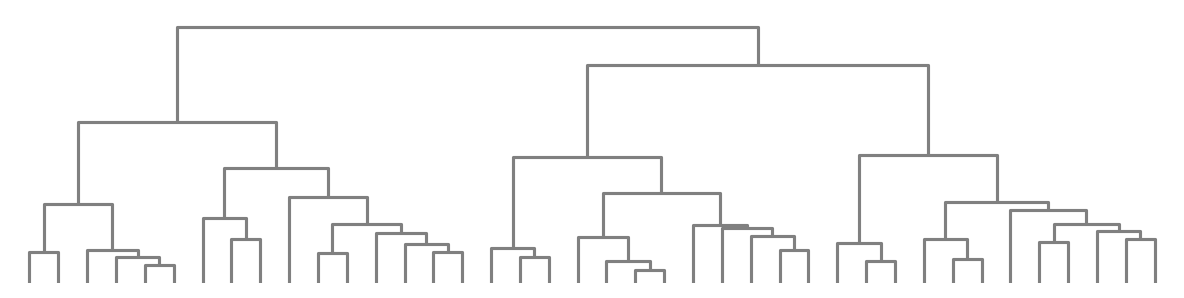

In [20]:
##NOTE
# this code is ran multiple times: 1st time image is saved with labels
# second time - without, to incorporate into the plot


a,fig,gs = rz.startfig(20,5)
col_link = hierdict['col_link']
dendro = scipy.cluster.hierarchy.dendrogram(
                                 col_link, orientation='top', ax=a,
                                 above_threshold_color='0.5',
                                 color_threshold = 0,
                                    )

a.set_xticklabels(heat.columns,rotation=270,fontsize=5)
a.set_xticks([])
a.axis('off')
rz.showspines(a)

gs.tight_layout(fig)
fname = outdir+'/dendrogram15_new_without_labels_%s.pdf'%(rz.now())
print(fname)
plt.savefig(fname, transparent=True, dpi=400)

In [21]:
heat2 = heat

In [22]:
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [23]:
#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='cmap', 
    colors=['#4d4dff', #blue
            '#D3D3D3', #grey
            '#cc0000' #dark-red
           ])

In [24]:
heat.columns

Index(['Non-classical monocytes', 'Classical monocytes', 'TAM 4', 'TAM 1',
       'TAM 3', 'TAM 2', 'B cells', 'IGHG-high plasma cells', 'Plasma cells',
       'Mast cells', 'Cytotoxic T cells', 'NK cells', 'Cycling',
       'Regulatory T cells', 'CD8 T cells', 'Resting/memory T cells',
       'Myofibroblasts', 'Mesangial/vSMCs', 'vSMCs', 'Tumor vasculature 3',
       'Tumor vasculature 2', 'Tumor vasculature 4', 'Tumor vasculature 1',
       'Podocytes', 'Tumor AVR-like vasculature', 'DVR', 'AVR',
       'Glomerular endothelium', 'Tumor cells 1', 'Tumor cells 2',
       'Tumor cells 3', 'Type B-IC', 'Type A-ICs', 'OM Type A-ICs',
       'Proximal tubule', 'Principal cells', 'DCT/CNT', 'TAL of LOH',
       'Epithelial progenitor-like cells', 'tAL of LOH'],
      dtype='object')

In [25]:
# select gene names to print in the heatmap


totick = [
    #'Non-classical monocytes'
    'LST1',
    #'Classical monocytes', 
    'S100A9',
    #'TAM 4', 
    'C1QB', 'C1QA',
    #'TAM 1',
    'IL1B', 'CXCL8',
    #'TAM 3',
    'HLA-DPB1', 
    #'TAM 2', 
    'APOC1', 'APOE', '',
    #'B cells', 
    'CD79A',
    #'IGHG-high plasma cells',
    'IGHG1',
    #'Plasma cells',
    'IGHA1', '',
    #'Mast cells',
    'TPSB2',
    #'Cytotoxic T cells',
    'XCL1',
    #'NK cells', 
    'GZMB', '', '',
    #'Cycling',
    'MKI67',
    #'Regulatory T cells',
    'FOXP3',
    #'CD8 T cells',
    'DUSP4', 'CD8B',
    #'Resting/memory T cells',
    'IL7R', 'CD52', '',
    #'Myofibroblasts', 
    'COL1A1', 
    #'Mesangial/vSMCs', 
    'BGN', 
    #'vSMCs',
    'ACTA2', 'TAGLN', '',
    #'Tumor AVR-like vasculature', 
    'ACKR1', 'VWF',
    #'Tumor vasculature 3',
    'LY6H', 
    #'Tumor vasculature 2',
    'ENPP2',
    #'Tumor vasculature 4',
    'PLVAP',
    #'Tumor vasculature 1',
    'SPARC', '',
    #'Podocytes',
    'NPHS2',
    #'DVR', 
    'AQP1',
    #'AVR', 
    'DNASE1L3',
    #'Glomerular endothelium', 
    'EMCN', 'SOST', '',
    #'Tumor cells 1',
    'SLC17A3',
    #'Tumor cells 2', 
    'NDUFA4L2', 'VEGFA',
    #'Tumor cells 3',
    'BNIP3', '',
    #'Type B-IC', 
    'KRT7',
    #'Type A-ICs',
    'ATP6V1G3',
    #'OM Type A-ICs',
    'SLC4A1','ATP6V0D2',
    #'Proximal tubule', 
    'ALDOB', 'MT1G',
    #'Principal cells', 
    'FXYD4', 'AQP2',
    #'DCT/CNT',
    'CALB1', 'SLC12A3',
    #'TAL of LOH', 
    'UMOD', 
    #'Epithelial progenitor-like cells', 
    'CRYAB', 'MMP7', 'CD24',
    #'tAL of LOH'
    'S100A2'
]

In [26]:
#changing the order 
totick = [
    'HLA-DPB1', 'APOE','C1QB',
 'C1QA', 'APOC1', 'CXCL8', 'IL1B', 'LST1','',
 'S100A9',
 '','','',
 'CD79A',
 'IGHG1',
 'IGHA1',
 '','','','',
 'XCL1','GZMB','CD52', 'CD8B', 'DUSP4','FOXP3',
 'IL7R', 
    '',
 'TPSB2',
 '', 
 'MKI67',
 '',
 'BGN',
 'ACTA2',
 'TAGLN',
 'COL1A1',
 '',
 'LY6H',
 'ENPP2',
 'PLVAP',
 'VWF',
 'SOST',

 '',
 'NPHS2',
 '',
 
 '',
 'SPARC',
 'AQP1',
 'DNASE1L3',
 'EMCN',
 'ACKR1',
 '',
 'CD24',
 'BNIP3',
 'CRYAB',
 'SLC17A3',
    '',
 'NDUFA4L2',
 'VEGFA',
 '',
 'MT1G',
 'ALDOB',
 'SLC4A1',
 'ATP6V1G3',
 'ATP6V0D2',
 'UMOD',
 'MMP7',
 'CALB1',
 'SLC12A3',
 'FXYD4',
 'AQP2',
 'KRT7',
 'S100A2']

In [27]:
adata.obs['group_color'].unique()

array(['#85619c', '#db2f2c', '#e07c57', '#4f9e58', '#d65a5a', '#5e5e5e',
       '#477ead'], dtype=object)

In [28]:
# select gene names to print in the heatmap
color_dict = {
    #'Non-classical monocytes'
    'LST1' : '#85619c',
    #'Classical monocytes', 
    'S100A9' : '#85619c',
    #'TAM 4', 
    'C1QB':'#85619c', 'C1QA':'#85619c',
    #'TAM 1',
    'IL1B':'#85619c', 'CXCL8':'#85619c',
    #'TAM 3',
    'HLA-DPB1':'#85619c', 
    #'TAM 2', 
    'APOC1':'#85619c', 'APOE':'#85619c',
    #'B cells', 
    'CD79A':'#4f9e58',
    #'IGHG-high plasma cells',
    'IGHG1':'#4f9e58',
    #'Plasma cells',
    'IGHA1':'#4f9e58', 
    #'Mast cells',
    'TPSB2':'#85619c',
    #'Cytotoxic T cells',
    'XCL1':'#4f9e58',
    #'NK cells', 
    'GZMB':'#4f9e58', 
    #'Cycling',
    'MKI67':'#5e5e5e',
    #'Regulatory T cells',
    'FOXP3':'#4f9e58',
    #'CD8 T cells',
    'DUSP4':'#4f9e58', 'CD8B':'#4f9e58',
    #'Resting/memory T cells',
    'IL7R':'#4f9e58', 'CD52':'#4f9e58',
    #'Myofibroblasts', 
    'COL1A1':'#d65a5a', 
    #'Mesangial/vSMCs', 
    'BGN':'#d65a5a', 
    #'vSMCs',
    'ACTA2':'#d65a5a', 'TAGLN':'#d65a5a', 
    #'Tumor AVR-like vasculature', 
    'ACKR1':'#e07c57', 'VWF':'#e07c57',
    #'Tumor vasculature 3',
    'LY6H':'#e07c57', 
    #'Tumor vasculature 2',
    'ENPP2':'#e07c57',
    #'Tumor vasculature 4',
    'PLVAP':'#e07c57',
    #'Tumor vasculature 1',
    'SPARC':'#e07c57', 
    #'Podocytes',
    'NPHS2':'#477ead',
    #'DVR', 
    'AQP1':'#e07c57',
    #'AVR', 
    'DNASE1L3':'#e07c57',
    #'Glomerular endothelium', 
    'EMCN':'#e07c57', 'SOST':'#e07c57', 
    #'Tumor cells 1',
    'SLC17A3':'#db2f2c',
    #'Tumor cells 2', 
    'NDUFA4L2':'#db2f2c', 'VEGFA':'#db2f2c',
    #'Tumor cells 3',
    'BNIP3':'#db2f2c', 
    #'Type B-IC', 
    'KRT7':'#477ead',
    #'Type A-ICs',
    'ATP6V1G3':'#477ead',
    #'OM Type A-ICs',
    'SLC4A1':'#477ead','ATP6V0D2':'#477ead',
    #'Proximal tubule', 
    'ALDOB':'#477ead', 'MT1G':'#477ead',
    #'Principal cells', 
    'FXYD4':'#477ead', 'AQP2':'#477ead',
    #'DCT/CNT',
    'CALB1':'#477ead', 'SLC12A3':'#477ead',
    #'TAL of LOH', 
    'UMOD':'#477ead', 
    #'Epithelial progenitor-like cells', 
    'CRYAB':'#477ead', 'MMP7':'#477ead', 'CD24':'#477ead',
    #'tAL of LOH'
    'S100A2':'#477ead'
    
}

In [29]:

def yticks_fancy(a,totick,labels_all, color_dict,emptychar = '',fontsize=5):
    
    """
    utility function originally made for ticking only a subset of selected genes in a genes x observations heatmap.
    example of use: yticks_fancy(a,['Csf1r','Ccr2','','','Arg1','S100a9'],genes_by_cells.index)
    input:
        a - axis with heatmap
        totick - list of yticklabels to display. Use the string defined by
        emptychar to add spacing between groups of genes.
        labels_all - all yticklabels.
        emptychar - string that will be treated as white space
        
    returns: nothing
    
    """


    a.set_yticks([])
    leftshift = 0
    totick = np.array(totick)
    nr_slots = len(totick)
    tickmask = np.array([i!=emptychar for i in totick])
    totick = totick[tickmask]
    y_right = np.array([pd.Index(labels_all).get_loc(i) for i in totick])
    
    #if genes were not typed in in the correct order, account for that to avoid lines crossing
    tickorder = np.argsort(y_right)
    y_right = y_right[tickorder]
    totick = totick[tickorder]
    y_left = np.linspace(0,len(labels_all),nr_slots)[tickmask]
    for l,r,gene in zip(y_left,y_right,totick):
        a.plot((-0.8-leftshift,-0.5-leftshift),(r,r),lw=0.5,color='0.2')
        a.plot((-1.2-leftshift,-0.8-leftshift),(l,r),lw=0.5,color='0.2')
        a.plot((-1.5-leftshift,-1.2-leftshift),(l,l),lw=0.5,color='0.2')
        a.text(-1.6-(leftshift*1.6),l,gene,ha='right',va='center',fontsize=fontsize, color = color_dict[gene])

-2.9527953728299203 9.759080123725687
final_heatmap_cell_type_upto_15_230713_13h58


<ipython-input-32-85489e7bfc78>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig)


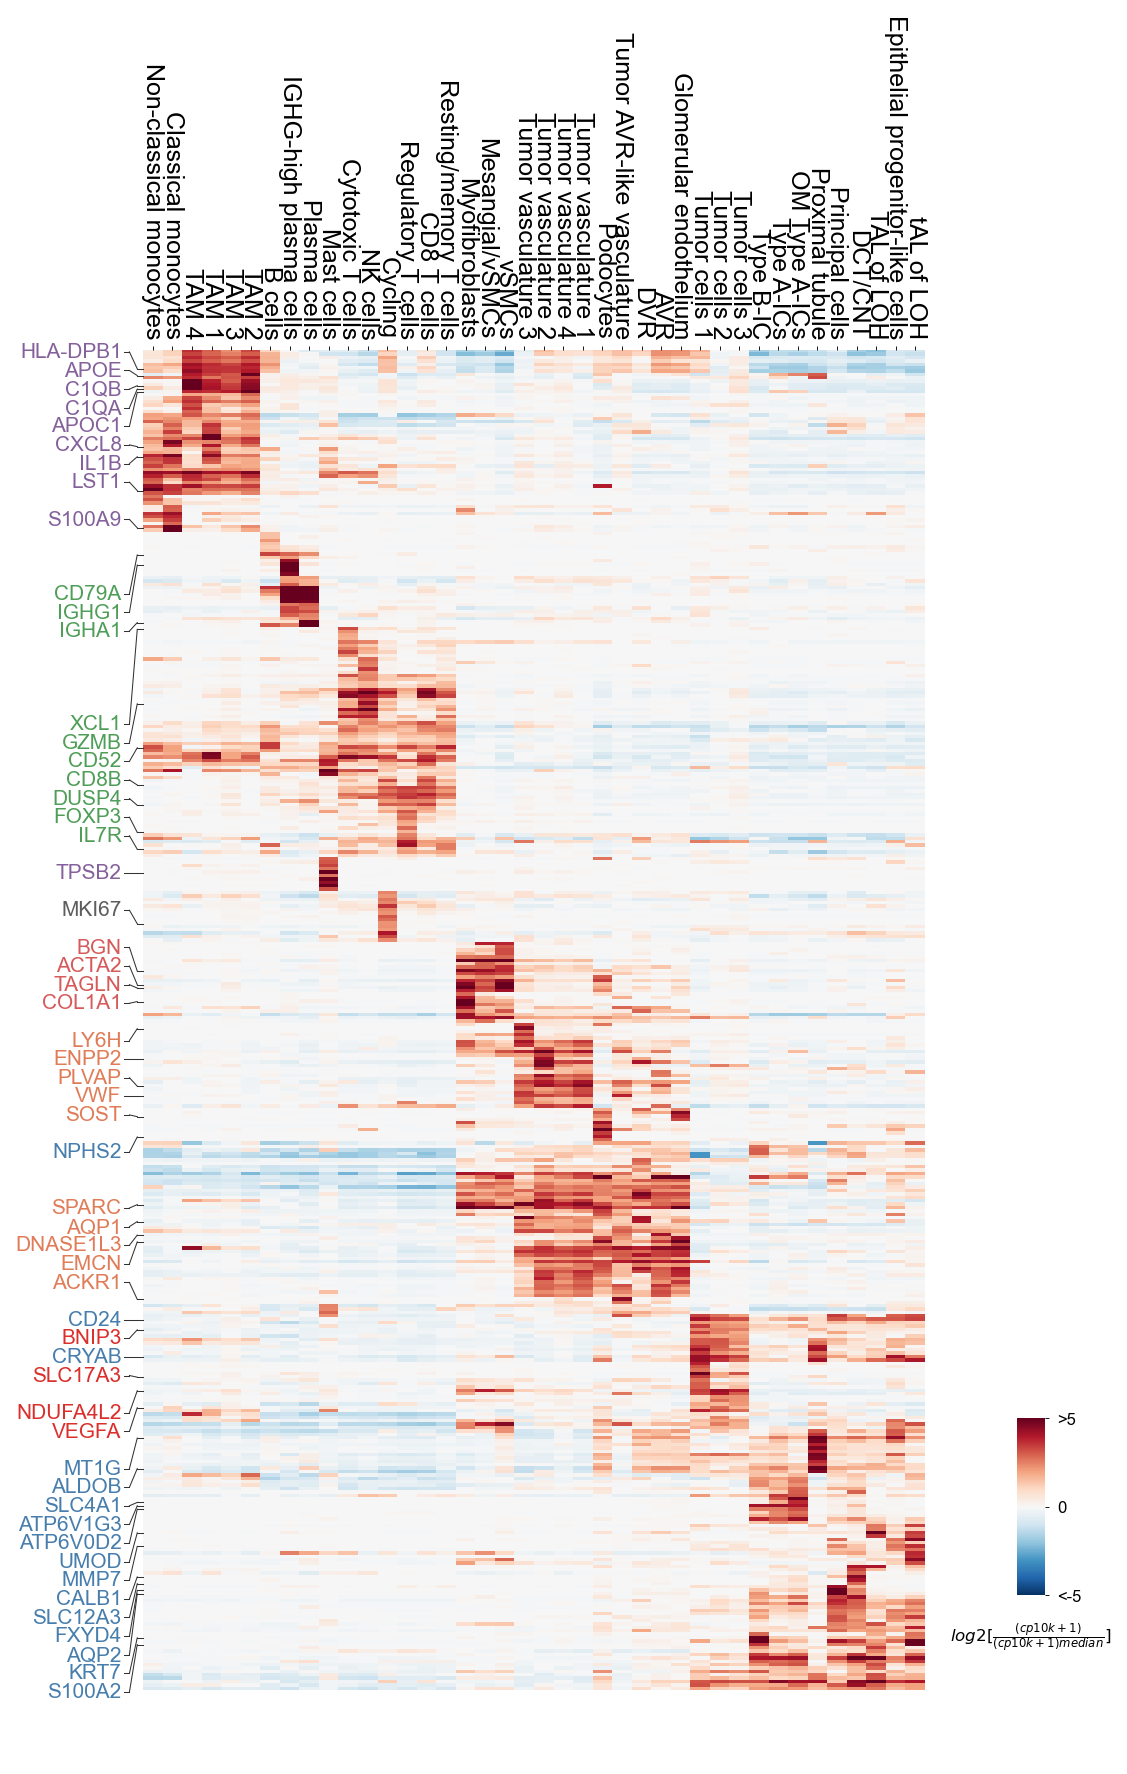

In [32]:
a,fig,gs = rz.startfig(16,30,frameon=False)

upto=15
cmap = 'RdBu_r'
cbarlabel = r'$log2[\frac{(cp10k+1)}{(cp10k+1) median}]$'

vmin=-5
vmax=5
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap, interpolation='none')

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270, fontsize=12)
a.xaxis.tick_top()

# y ticks
yticks_fancy(a,totick,labels_all = heat.index, color_dict=color_dict, fontsize=10)

#a.set_yticks(np.arange(heat.shape[0]))
#a.set_yticklabels(to_tick,fontsize=5)

# colorbar
#cbar = fig.colorbar(hmap,orientation='vertical')
#cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]


#norm = mpl.colors.Normalize(vmin, vmax)
caxb = fig.add_axes([1.08, 0.1, 0.03, 0.1])
cbar = fig.colorbar(hmap, cax=caxb, orientation='vertical')
cbar.outline.set_visible(False)
#c = [vmin, 0,  vmax]
cbar.set_ticks(c)
cbar.ax.set_yticklabels(clabs, fontsize = 8)
cbar.set_ticklabels(clabs)
cbar.ax.set_title(cbarlabel,
                  fontsize=8, pad = 20, y=-0.5)

gs.tight_layout(fig)
fname = 'final_heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=400)
plt.savefig(outdir+'%s.pdf'%fname,dpi=400,  bbox_inches='tight')